Instanciamos modelos:
- GloVe
- Bert en español
- PersonalityBert multilenguaje


- Armamos una prueba para cada [Música, Empatía, Visión]:
   Para cada [GloVe, Beto, PersonalityBertML]:
  - Vector de referencia con palabras seleccionadas
  - Lista y gráfico con palabras más cercanas a referencia
  - Separación en dos grupos usando objetivo estandarizado
  - Prueba de hipótesis
  - Clasificación de esa característica con fine tuning de T5

Instanciar Glove, Word2Vec, Fastext


* Pasar texto de pdf en español y de "tesis en construccion" lo q pinte de eso 
* Replicar las comparaciones que se hacen acá con GLove, con Bert embeddings (fixed-width)
* Hacer lo que hay en BETO con glove
* Revisar explicaciones de todo 
* La métrica de las trayectorias
* Prueba de hipótesis
* Dash con gráfico


# Preparación

In [6]:
!pip install unidecode
!pip install umap-learn

     |████████████████████████████████| 245kB 2.8MB/s 


In [7]:
# importamos
import numpy as np
import pandas as pd
import scipy.stats as st
import unidecode
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import IPython
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Instanciamos modelos

### Glove

In [8]:
%%time
# instalamos librerias
#!python -m spacy download es_core_news_md

# Si quisieramos usar otros embeddings:
# https://github.com/uchile-nlp/spanish-word-embeddings
!wget -nc http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
!python -m spacy init-model es /mindspace --vectors-loc glove-sbwc.i25.vec.gz

--2020-06-09 21:19:55--  http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
Resolving dcc.uchile.cl (dcc.uchile.cl)... 192.80.24.11
Connecting to dcc.uchile.cl (dcc.uchile.cl)|192.80.24.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz [following]
--2020-06-09 21:19:56--  https://www.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
Resolving www.dcc.uchile.cl (www.dcc.uchile.cl)... 192.80.24.11, 200.9.99.213
Connecting to www.dcc.uchile.cl (www.dcc.uchile.cl)|192.80.24.11|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://users.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz [following]
--2020-06-09 21:19:57--  https://users.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (u

In [0]:
# Cargamos la data del modulo para español
nlp = spacy.load('/mindspace')

### Transformer

In [10]:
# Transfomers
# Instalamos libreria y descargamos los modelos de github

!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     |████████████████████████████████| 675kB 2.9MB/s 
     |████████████████████████████████| 1.1MB 14.0MB/s 
     |████████████████████████████████| 890kB 19.2MB/s 
     |████████████████████████████████| 3.8MB 24.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c823f6de53ba01de8922a4ea35c45eb1f1045599922f3180d8b3bacddcd030ba
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
--2020-06-09 21:24:43--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 390.88M  11.3MB/s    in 34s     

2

In [11]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", do_lower_case=False)
model = BertForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

## Preprocesamiento

In [12]:
# las 50.000 palabras de español mas usadas en subtitulos de peliculas
voc = pd.read_csv('https://github.com/hermitdave/FrequencyWords/raw/master/content/2018/es/es_50k.txt', sep=' ', header=None)
voc.columns = ['Palabras', 'Freq']
voc = voc.set_index('Palabras')
voc.sample(2)

,Freq
Palabras,
centramos,268
agüero,253


In [13]:
stop_words = pd.read_csv('https://github.com/Alir3z4/stop-words/raw/master/spanish.txt', sep='\n', header=None)
stop_words = set(stopwords.words('spanish'))
np.random.choice(list(stop_words), 4)

array(['quienes', 'tanto', 'estábamos', 'hubiste'], dtype='<U12')

In [14]:
#palabras generales de referencia
palabras = pd.read_csv('https://github.com/institutohumai/sesgos/raw/master/data/palabras.csv', encoding = 'utf8').columns.values
palabras[:4]

array(['empatía', ' empatia', ' hola', ' odio'], dtype=object)

In [0]:
# filtro de las 800.000 las que se corresponden con las 50.000 mas usadas y saco las stopwords
# con el ampersand se queda . con lo que cruza, con diference le resta las stopwords
# me quedo con los embeddings de esas palabras solamente
# vecs = vecs.loc[(voc.index & vecs.index).difference(set(stop.values.flat))]
# vecs.shape

# Pruebas

### Funciones para pruebas

In [0]:
# Calcular distancia coseno entre vectores. El arroba es producto interno
def similitud_coseno(x, y):
    return x @ y / (np.linalg.norm(x) * np.linalg.norm(y))

In [0]:
# version rápida
import numba
@numba.jit(target='cpu', nopython=True)
def similitud_coseno(u, v):
    m = u.shape[0]
    udotv = 0
    u_norm = 0
    v_norm = 0
    for i in range(m):
        if (np.isnan(u[i])) or (np.isnan(v[i])):
            continue
            
        udotv += u[i] * v[i]
        u_norm += u[i] * u[i]
        v_norm += v[i] * v[i]

    u_norm = np.sqrt(u_norm)
    v_norm = np.sqrt(v_norm)
    
    if (u_norm == 0) or (v_norm == 0):
        ratio = 1.0
    else:
        ratio = udotv / (u_norm * v_norm)
    return ratio

In [0]:
def str2bert(x):
  tokens = tokenizer.encode(x)
  input_ids = torch.tensor(tokens).unsqueeze(0)  # Batch size 1
  outputs = model(input_ids)
  hidden = outputs[0][-1][0]
  return hidden.detach().numpy()

In [0]:
def most_similar(vector, other_vectors):
  from scipy.spatial.distance import cosine

  scores = [cosine(vector, vec) for vec in other_vectors]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
  return ranked_candidates

In [0]:
def plot3D_sentences(sentences, svectors, colours, umap=False):
  from sklearn.decomposition import PCA
  redux = PCA(n_components=3)
  principalComponents = redux.fit_transform(svectors)
  if umap:
    redux = umap.UMAP(n_components=3)
    redux = (redux-redux.mean())/(redux.std())
    principalComponents = redux.fit_transform(svectors)
  df = pd.DataFrame(data = principalComponents, columns = ['x', 'y','z'])
  df['color'] = pd.Series([sns.color_palette("GnBu_d").as_hex()[i] for i in colours])
  df.index = sentences
  plot3d(df)

def plot3d(coords, title=''):
  scatter = go.Scatter3d(
              x=coords['x'],
              y=coords['y'],
              z=coords['z'],
              text=coords.index,
              textposition='top center',
              showlegend=False,
              mode='markers+text',
              hoverinfo='text',
              textfont=dict(color=coords['color']),#, size=19.2),
              marker=dict(
                  size=6,
                  symbol='circle',
                  color = coords['color']
              )
          )

    
  layout = go.Layout(
      title=title,
      width=1080,
      height=960,
      scene=dict(xaxis={'showbackground':False,
                        'gridcolor':'rgba(0,0,40,0.4)'},
                 yaxis={'showbackground':False,
                        'gridcolor':'rgba(0,0,40,0.4)'},
                 zaxis={'showbackground':False,
                        'gridcolor':'rgba(0,0,40,0.4)'}),
      )

  fig = go.Figure(data=[scatter], layout = layout)
  iplot(fig, validate=False)

In [0]:
def plotear_vecinos(palabra, n = 200):
  cercanas = encontrar_cercanas(palabra)
  df = redux.loc[cercanas.index[:n]]
  plot3d(df, w = palabra)

In [0]:
def glove_vector(sentence):
  return nlp(sentence).vector

In [0]:
def embed(string, how='glove'):
  if how.lower() == 'bert':
    return str2bert(string[:2000])
  elif how.lower() == 'glove':
    return nlp(string).vector 

In [0]:
def pairwise(e1, e2, r1, r2, w = 'e1 e2 r1 r2', distfunc=similitud_coseno):
  we1, we2, wr1, wr2 = w.split()
  print(f'|{we1} - {wr1}|'.ljust(25)+ f'{distfunc(e1, r1):.3f}')
  print(f'|{we2} - {wr1}|'.ljust(25)+ f'{distfunc(e2, r1):.3f}')
  print(f'|{we1} - {wr2}|'.ljust(25)+ f'{distfunc(e1, r2):.3f}')
  print(f'|{we2} - {wr2}|'.ljust(25)+ f'{distfunc(e2, r2):.3f}')

### Referencias y ejemplos

In [0]:
#old

str_vision = ' '.join(('fotografía','imagen','color','forma','contorno','linea','ojos'))
str_empatia = ' '.join(('empatía', 'compasión', 'solidaridad', 'solidario', 'amor'))
str_dolor = ' '.join(('herida', 'pena', 'disgusto', 'tristeza', 'quemadura', 'pinchar', 'dolor'))
str_intelecto = ' '.join(('cerebro', 'inteligencia', 'genio', 'logica'))
str_sonido = ' '.join(('sonido','grave','agudo', 'tono', 'escuchar', 'oir', 'cantar','guitarra','agudo', 'tono', 'escuchar', 'concierto'))

ej_musico = "el video muestra una escena en una playa, se escucha la gente riendo y jugando. El mar está tranquilo, apenas se escucha el sonido de las olas, y el cielo despejado. Hay una pareja con un chico, que se alejó para jugar con una pelotita. Hay un grupo de adolescentes lejos hacia la derecha donde uno toca la guitarra."
ej_fotografo = "Se ve un día soleado de verano en una playa, con vistas al horizonte. Hay una pareja acostada sobre una manta verde y violeta de figuras geométricas, y varias sombrillas celestes a la izquierda. A lo lejos se ve el mar, con agua bastante clara. El hombre de la pareja tiene un bigote y aparenta unos 45 años, la mujer está de espaldas."

wiki_musico = 'Un músico o una música1 es una persona que se dedica a la composición, interpretación y/o edición de la música. Los músicos se pueden clasificar en dos grandes categorías: compositor y trovador.'

In [0]:
str_vision = 'color forma mirar visión'
str_empatia = 'empatía amor amar'
str_sonido = 'sonido música'

ej_musico = "El video muestra una escena en una playa, se escucha la gente riendo y jugando. El mar está tranquilo, apenas se escucha el sonido de las olas, y el cielo despejado. Hay un grupo de adolescentes lejos hacia la derecha donde uno toca la guitarra."
ej_fotografo = "Se ve un día soleado de verano en una playa, con vistas al horizonte. Hay una pareja acostada sobre una manta verde y violeta de figuras geométricas, y varias sombrillas celestes a la izquierda. A lo lejos se ve el mar, con agua bastante clara. El hombre de la pareja tiene un bigote y aparenta unos 45 años, la mujer está de espaldas."

hamilton = 'El hamiltoniano cuántico H es el observable que representa la energía total del sistema (formalmente se define como un operador autoadjunto definido sobre un dominio denso en el espacio de Hilbert del sistema). Los posibles valores de la energía de un sistema físico vienen dados por los valores propios del operador hamiltoniano'
wiki_musico = 'Un músico o una música1 es una persona que se dedica a la composición, interpretación y/o edición de la música. Los músicos se pueden clasificar en dos grandes categorías: compositor y trovador.'
str_spinetta = 'Si a tu corazón yo llego igual, todo siempre se podrá elegir. No me escribas la pared, solo quiero estar entre tu piel. Y si acaso no brillara el sl, y quedara yo atrapado aquí No vería la razón en seguir viviendo sin tu amor Y hoy que, enloquecido vuelvo buscando tu querer. No queda mas que viento, no queda mas que viento. Y si acaso no brillara el sol, y quedara yo atrapado aquí No vería la razón de seguir viviendo sin tu amor, ah Oh! Y hoy que, enloquecido, vuelvo! Buscando tu querer No queda mas que viento, no, no queda mas que viento Y si acaso no brillara el sol y quedara yo atrapado aquí No vería la razón de seguir viviendo sin tu amor'
str_musica = 'Arte de combinar los sonidos en una secuencia temporal atendiendo a las leyes de la armonía, la melodía y el ritmo, o de producirlos con instrumentos'

In [27]:
# Ejemplos

for m in ['GloVe', 'BERT']:
  print(m)
  sonido = embed(str_sonido, m)
  vision = embed(str_vision, m)
  musico = embed(ej_musico, m)
  fotografo = embed(ej_fotografo, m)
  pairwise(musico, fotografo, sonido, vision, w = 'Musico Fotografo Sonido Vision')
  print()
  wiki_mus = embed(wiki_musico, m)
  musica = embed(str_musica, m)
  spinetta = embed(str_spinetta, m)
  math = embed(hamilton, m)
  pairwise(wiki_mus, spinetta, musica, math, w = 'WikiMus Spinetta DefMus Math')
  print()

GloVe
|Musico - Sonido|        0.606
|Fotografo - Sonido|     0.510
|Musico - Vision|        0.764
|Fotografo - Vision|     0.788

|WikiMus - DefMus|       0.954
|Spinetta - DefMus|      0.872
|WikiMus - Math|         0.908
|Spinetta - Math|        0.860

BERT
|Musico - Sonido|        0.836
|Fotografo - Sonido|     0.829
|Musico - Vision|        0.849
|Fotografo - Vision|     0.832

|WikiMus - DefMus|       0.823
|Spinetta - DefMus|      0.769
|WikiMus - Math|         0.821
|Spinetta - Math|        0.803



In [0]:
example_sentences = [
    # ML
    "circuitos neurobiológicos como algoritmo computacional para el aprendizaje estadístico",
    "aprendizaje automático o machine learning (ML), que consiste en programas que aprenden a mejorar en una tarea, medida con una métrica particular",
    "técnicas de estadística multivariada se construye una arquitectura probabilística para resolver la tarea",

    # Psi
    "Mediante el lenguaje, se pueden contemplar tantas caracterı́sticas del hablante como nivel de alerta, años de educación, profesión, o detectar trastornos de la salud como condiciones psiquiátricas",
    "Las palabras que usamos en nuestras vida diaria pueden revelar aspectos importantes de nuestros mundos sociales y psicológicos.",

    "Hoy pasó algo buenísimo, me siento muy contento",
    "Qué tragedia lo que ocurrió",


    "Cantar y bailar escuchando el sonar de las trompetas"
    "El sonido del viento, el rugir de las olas"
]

topics = [0, 0, 0, 1, 1, 2,2, 3,3]

In [124]:
m = 'glove'
vectors = [embed(s, m) for s in example_sentences]
most_similar(embed("computadora", m), vectors)

['circuitos neurobiológicos como algoritmo computacional para el aprendizaje estadístico',
 'aprendizaje automático o machine learning (ML), que consiste en programas que aprenden a mejorar en una tarea, medida con una métrica particular',
 'técnicas de estadística multivariada se construye una arquitectura probabilística para resolver la tarea']

In [125]:
# Ploteamos
plot3D_sentences(example_sentences, vectors, topics)

# Análisis

In [31]:
!wget https://github.com/institutohumai/sesgos/raw/master/data/data.7z
!7z x data.7z -pneurocomp

--2020-06-09 21:27:16--  https://github.com/institutohumai/sesgos/raw/master/data/data.7z
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/institutohumai/sesgos/master/data/data.7z [following]
--2020-06-09 21:27:17--  https://raw.githubusercontent.com/institutohumai/sesgos/master/data/data.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102971 (101K) [application/octet-stream]
Saving to: ‘data.7z’

data.7z             100%[===================>] 100.56K  --.-KB/s    in 0.04s   

2020-06-09 21:27:17 (2.67 MB/s) - ‘data.7z’ saved [102971/102971]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov

In [0]:
import os
import pandas as pd
import json
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [0]:
def leer_archivo(f):
    """recibe path al archivo y devuelve DataFrame"""
    with open(f, 'rb') as inp:
        j = json.loads(inp.read().decode('latin1'))
    return pd.read_json(j)

In [0]:
def get_respuestas(df):
    data = {}
    for r in range(df.shape[0]):
        d = df['responses'][r]
        if pd.isna(d):
            continue
        for k, v in d.items():
            n_pregunta = re.search('\d+', k).group(0)
            data[df['etapa'][r] + n_pregunta] = v
    return data

In [0]:
# funcion para pasar de los datos crudos a tuplas con (n_imagen, x, y)

def colors2tuples(x):
    return sorted([(int(re.search('(\d+).png', d['src']).group(1)), d['x'], d['y']) for d in eval(x.dropna().values[0])], key=lambda x: x[1])

In [0]:
# necesitamos algo como 
# rt, data, 
# ahora tenemos:
# button pressed, locations, responses, rt

def get_data(path):
    etapas = ['bienvenida', 'consentimiento', 'pre_hist', 'historia', 'instruct_vid', 'video1', 'descripcion', 'video2',
         'descripcion1', 'colores', 'audio1', 'audio2',  'audio3', 'mate', 'empatia', 'academia',
         'personales', 'genero', 'yacasi', 'años', 'horas', 'subjetivo', 'recuerdo', 'despedida']
    corr = ['alegr', 'preocup', 'deseos', 'insist', 'preocup', 'soña', 'inc', 'desanim', 'entusm', 'caute']
    exactos = ['ing', 'sist', 'comput', 'fisica', 'matem']
    
    df = leer_archivo(path)
    df['responses'] = df['responses'].apply(lambda x: eval(x) if type(x) == str else x)
    df['etapa'] = etapas[:df.shape[0]]
    data = get_respuestas(df[['responses', 'etapa']])
    data['audioperceptiva'] = (df[df['etapa'].str.contains('audio')]['button_pressed'] == [0,1,0]).sum()
    data['genero'] = df.loc[df['etapa'] == 'genero', 'response'].values[0]
    data['colores'] = colors2tuples(df['final_locations'])
    data['exacto'] = np.any([t in data['academia1'].lower() for t in exactos])
    data['celular'] = (df['init_locations'].dropna() == df['final_locations'].dropna()).values[0]
    data['tiempos'] = df['rt'].values.tolist()
    data['mate0'] = (data['mate0'] == '0,05')
    data['eyes'] = sum([corr[i] in data['empatia' + str(i)].lower() for i in range(1, 10)])
    data['personales1'] = [match.groups(1)[0] if match else None for match in [re.search('(\d+)', data['personales1'])]][0]
    data = {k:v for k,v in data.items() if 'empat' not in k}
    return data, df

In [0]:
# lista con todos los nombres de archivos
txts = [r'/content/data/' + f for f in os.listdir('/content/data') if f.endswith('.json')]

In [38]:
# junta todo en un DF
data = []
for txt in txts:
    data_, df_ = get_data(txt)
    data.append(data_)
df = pd.DataFrame(data)
df.shape

(84, 61)

In [39]:
df.sample()

,descripcion0,descripcion10,mate0,academia0,academia1,academia2,academia3,personales0,personales1,personales2,personales3,personales4,personales5,años0,años1,años2,años3,años4,años5,años6,años7,horas0,horas1,horas2,horas3,horas4,horas5,horas6,horas7,horas8,horas9,horas10,horas11,horas12,subjetivo0,subjetivo1,subjetivo2,subjetivo3,subjetivo4,subjetivo5,subjetivo6,subjetivo7,subjetivo8,subjetivo9,subjetivo10,subjetivo11,subjetivo12,subjetivo13,subjetivo14,subjetivo15,subjetivo16,subjetivo17,subjetivo18,recuerdo0,audioperceptiva,genero,colores,exacto,celular,tiempos,eyes
58,Al comienzo del video se puede ver a una niña y un niño orientales jugando en el suelo.\nElla tiene puesto un vestido azul y juega con una muñeca.\nEl está vestido de blanco y juega con autos.\nLu...,"Al comienzo del video aparece un hombre blanco de pelo corto, castaño, lacio y con flequillo con apariencia entre los 20 y 30 años de edad.\nSe encuentra sentado en la entrada de una casa que tien...",True,Terciario completo,Comercio exterior,Un año,Estudio Kinesiología,Sabrina,29,7,Martínez,"153 cm, 47 kg",No,1,10 años,8,2,3,2,0 años (nada),0 años (nada),0-30,2-3,0 minutos,0-30,1-2 horas,0-30,0 minutos,0 minutos,0-30,0 minutos,0-30,0-30,0-30,10,7,9,10,10,10,10,10,10,10,10,10,10,8,8,10,9,9,5,Un hombre en un restaurante llama al mozo para quejarse.\nTiene una taza de café tibia y dulce.\nMueve su silla y realiza un sonido molesto con la msima.\nEl está ofuscado.\nEn frente hay un edifi...,1,0.0,"[(10, 0, 9), (9, 122, 8), (8, 243, 10), (7, 363, 10), (6, 478, 8), (5, 596, 10), (4, 707, 10), (3, 830, 10), (2, 945, 10), (1, 1055, 10)]",False,False,"[1375.0, 2957.0, 1247.0, 2647.0, 1559.0, nan, 278189.0, nan, 349398.0, 73814.0, 21014.0, 22319.0, 11823.0, 117749.0, 162639.0, 71413.0, 64734.0, 6567.0, 1671.0, 192616.0, 181852.0, 233913.0, 16374...",7


In [40]:
# porcentaje que lo hizo con celular
df['celular'].sum() / df.shape[0]

0.2261904761904762

In [0]:
def limpiar(txt):
  # ' '.join([unidecode.unidecode(w.string.strip()) for w in nlp(fotografo) if w.lemma_.lower() not in stop_words])
  return ' '.join([p.text for p in nlp(txt) if unidecode.unidecode(p.lemma_) in palabras]) # in palabras

In [0]:
str_sonido = 'música sonido grave agudo tono escuchar oir cantar guitarra piano'

In [0]:
# juntamos todo el texto ## podriamos hacerlo distinto!! separando las descripciones
df['texto'] = (df['descripcion0'] + ' ' + df['descripcion10'])#.apply(limpiar)  # + ' ' + df['recuerdo0'] ?

# calculamos la distancia a la ref para todos los sujetos
df['dist_glove'] = df['texto'].apply(lambda x: similitud_coseno(embed(str_sonido), embed(x)))

In [44]:
%%time
df['dist_bert'] = df['texto'].apply(lambda x: similitud_coseno(embed(str_sonido, 'bert'), embed(x, 'bert')))

CPU times: user 1min 52s, sys: 1.74 s, total: 1min 53s
Wall time: 1min 54s


In [45]:
df['audioperceptiva'].value_counts()

2    28
1    26
3    15
0    15
Name: audioperceptiva, dtype: int64

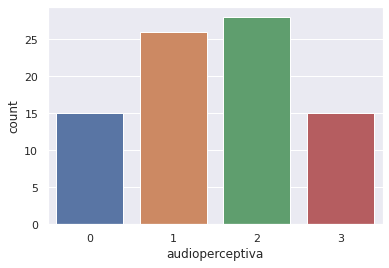

In [73]:
sns.countplot('audioperceptiva', data=df);

In [0]:
# definimos un indicador del grupo
df['es_exacto'] = (df['exacto'] == True) & (df['mate0'] == True)
df['es_musico'] = df['audioperceptiva'] > 1
df['es_hombre'] = df['genero'] > 99

In [48]:
df.shape, df['es_exacto'].sum(), df['es_musico'].sum(), df['es_hombre'].sum()

((84, 67), 16, 43, 40)

In [49]:
df['texto'].apply(lambda x: len(x)).describe()

count      84.000000
mean     1311.178571
std       395.850926
min       756.000000
25%      1144.500000
50%      1199.500000
75%      1332.000000
max      4013.000000
Name: texto, dtype: float64

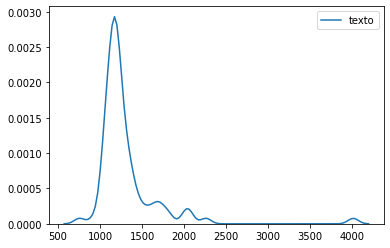

In [50]:
sns.kdeplot(df['texto'].apply(lambda x: len(x)))

In [0]:
sns.set()

## Preprocesamiento

## Estadística Descriptiva

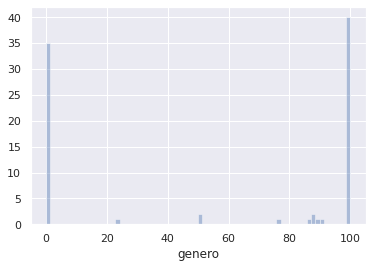

In [54]:
sns.distplot(df.loc[:,'genero'], bins=70, kde=False);

In [55]:
df.loc[:,'genero'].value_counts()

100.0    40
0.0      35
50.0      2
88.0      2
86.0      1
76.0      1
24.0      1
90.0      1
89.0      1
Name: genero, dtype: int64

In [56]:
df.shape[0]

84

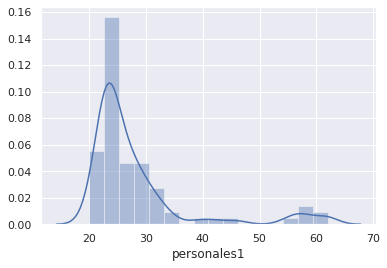

In [57]:
sns.distplot(df.loc[:,'personales1'].dropna().astype(int));

% correctos de exactas: 100.0
% correctos de no-exactas: 29.411764705882355


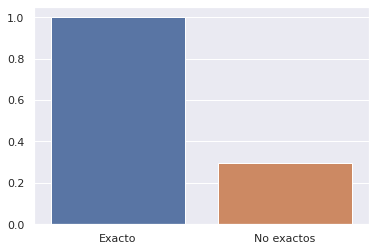

In [52]:
# Matemáticas
print('% correctos de exactas:', df[df['es_exacto'] == True]['mate0'].mean() * 100)
print('% correctos de no-exactas:', df[df['es_exacto'] == False]['mate0'].mean() * 100)
sns.barplot(x=['Exacto','No exactos'], y=[ df[df['es_exacto'] == True]['mate0'].sum() / df[df['es_exacto'] == True]['mate0'].count(),
                                           df[df['es_exacto'] == False]['mate0'].sum() / df[df['es_exacto'] == False]['mate0'].count()]);


Puntaje promedio para exactas: 4.25
Puntaje promedio para resto: 5.6911764705882355


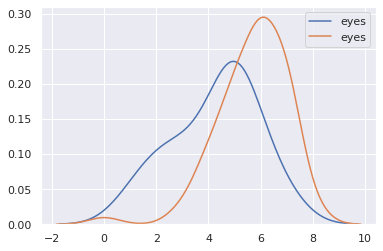

In [53]:
sns.kdeplot(df.loc[df['es_exacto'] == 1, 'eyes'])
sns.kdeplot(df.loc[df['es_exacto'] == 0, 'eyes']);
print('Puntaje promedio para exactas:', df[df['es_exacto'] == True]['eyes'].mean())
print('Puntaje promedio para resto:', df[df['es_exacto'] == False]['eyes'].mean())

In [126]:
st.normaltest(df['dist_glove'])

NormaltestResult(statistic=1.1772479565789387, pvalue=0.5550905761453808)

##  Musica

(0.13508707308594126, 0.22051233088908379)
SpearmanrResult(correlation=0.12228841308197726, pvalue=0.2677913223583836)
Ttest_indResult(statistic=-1.2345819844255486, pvalue=0.22051233088908498)
MannwhitneyuResult(statistic=757.0, pvalue=0.13358007557844032)


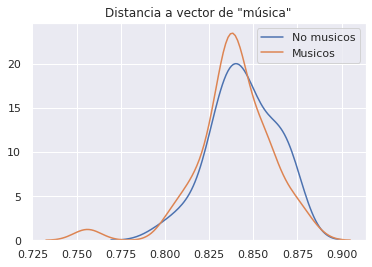

In [138]:
print(st.pearsonr(df['es_musico'], df['dist_bert']))
print(st.spearmanr(df['es_musico'], df['dist_bert']))
print(st.ttest_ind(df.loc[df['es_musico'] == 0, 'dist_bert'], df.loc[df['es_musico'] == 1, 'dist_bert']))
print(st.mannwhitneyu(df.loc[df['es_musico'] == 0, 'dist_bert'], df.loc[df['es_musico'] == 1, 'dist_bert']))

sns.kdeplot(df.loc[df['es_musico'] == 1, 'dist_bert'])
sns.kdeplot(df.loc[df['es_musico'] == 0, 'dist_bert'])
plt.legend(['No musicos', 'Musicos'])
plt.title('Distancia a vector de "música"')
plt.show()

(0.28039681278715634, 0.009782622801533435)
SpearmanrResult(correlation=0.23917452679085513, pvalue=0.028442228434105526)
Ttest_indResult(statistic=-2.6452161627731066, pvalue=0.009782622801533955)
MannwhitneyuResult(statistic=638.0, pvalue=0.014833452325632974)


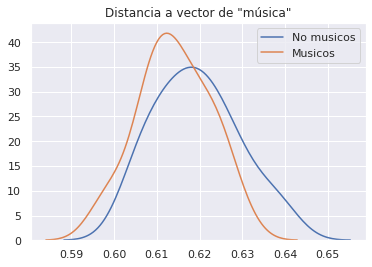

In [139]:
print(st.pearsonr(df['es_musico'], df['dist_glove']))
print(st.spearmanr(df['es_musico'], df['dist_glove']))
print(st.ttest_ind(df.loc[df['es_musico'] == 0, 'dist_glove'], df.loc[df['es_musico'] == 1, 'dist_glove']))
print(st.mannwhitneyu(df.loc[df['es_musico'] == 0, 'dist_glove'], df.loc[df['es_musico'] == 1, 'dist_glove']))

sns.kdeplot(df.loc[df['es_musico'] == 1, 'dist_glove'])
sns.kdeplot(df.loc[df['es_musico'] == 0, 'dist_glove'])
plt.legend(['No musicos', 'Musicos'])
plt.title('Distancia a vector de "música"')
plt.show()

In [61]:
st.spearmanr(df['es_musico'], df['dist_glove'])

SpearmanrResult(correlation=0.23917452679085513, pvalue=0.028442228434105526)

In [0]:
def test(txt, ref, distfunc=similitud_coseno, um = 0.15):
  txt = nlp(txt)
  r = 0
  for w in txt:
    dist = distfunc(embed(w.text, 'glove'), embed(w.text, 'glove'))
    if dist >= um:
      r += 1
  return r/len(txt)

In [133]:
%%time
df['n_mus'] = df['texto'].apply(lambda x: test(x, str_sonido))

CPU times: user 1.37 s, sys: 75.7 ms, total: 1.45 s
Wall time: 1.31 s


ValueError: ignored

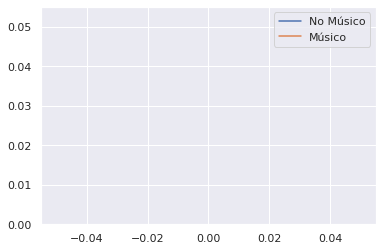

In [134]:
sns.kdeplot(df.loc[df['es_musico'] == 1, 'n_mus'])
sns.kdeplot(df.loc[df['es_musico'] == 0, 'n_mus'])
plt.legend(['No Músico', 'Músico'])
print(st.mannwhitneyu(df.loc[df['es_musico'] == 0, 'n_mus'], df.loc[df['es_musico'] == 1, 'n_mus']))
print(st.ttest_ind(df.loc[df['es_musico'] == 0, 'n_mus'], df.loc[df['es_musico'] == 1, 'n_mus']))

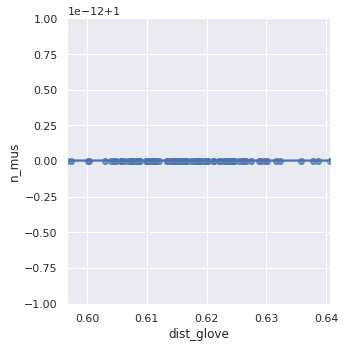

In [135]:
sns.lmplot(x='dist_glove', y='n_mus', data=df)

In [66]:
st.spearmanr(df['audioperceptiva'], df['dist_glove'])

SpearmanrResult(correlation=0.0963071270837903, pvalue=0.38349664626068447)

## Empatia

In [76]:
st.pearsonr(df['es_exacto'], df['mate0'])

(0.5601120336112041, 3.028153914851161e-08)

In [77]:
st.ttest_ind(df.loc[df['es_exacto'] == 0, 'eyes'], df.loc[df['es_exacto'] == 1, 'eyes'])

Ttest_indResult(statistic=3.695667224655664, pvalue=0.0003947071021139341)

Ttest_indResult(statistic=-1.175320430023876, pvalue=0.25426546142091877)

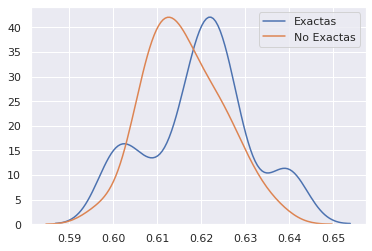

In [78]:
sns.kdeplot(df.loc[df['es_exacto'] == 1, 'dist_glove'])
sns.kdeplot(df.loc[df['es_exacto'] == 0, 'dist_glove'])
plt.legend(['Exactas', 'No Exactas'])
st.ttest_ind(df.loc[df['es_exacto'] == 0, 'dist_glove'], df.loc[df['es_exacto'] == 1, 'dist_glove'], equal_var=False)

In [0]:
df['n_empat'] = df['texto'].apply(lambda x: test(x, 'empatía'))

ValueError: ignored

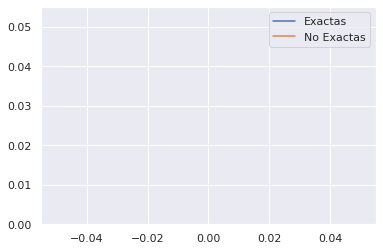

In [137]:
sns.kdeplot(df.loc[df['es_exacto'] == 1, 'n_empat'])
sns.kdeplot(df.loc[df['es_exacto'] == 0, 'n_empat'])
plt.legend(['Exactas', 'No Exactas'])
st.mannwhitneyu(df.loc[df['es_exacto'] == 0, 'n_empat'], df.loc[df['es_exacto'] == 1, 'n_empat'])

In [0]:
# normalizar x cant de palabras !!

In [0]:
# Prueba analogías 

In [0]:
!wget https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/questions-words_sp.txt

In [0]:
#https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume23/montoyo05a-html/node27.html

In [0]:
# si quisieramos usar como bases ejes conocidos
#file = 'bases.csv'
#i,j,w = 'feliz', 'dormido', 'futuro'
#vecs.loc[[i,j,w]].to_csv(file)
#i,j,w = vecs.loc[i], vecs.loc[j], vecs.loc[w]